In [1]:
"""
The original notebook is HF_Radar_Currents_west_coast.ipynb in
Theme_2_Extreme_Events/Scenario_2B/HF_Radar_Currents/
"""

title = "Near real-time current data"
name = '2015-10-26-HF_Radar_Currents_west_coast'

In [2]:
%matplotlib inline
import seaborn
seaborn.set(style='ticks')

import os
from datetime import datetime
from IPython.core.display import HTML

import warnings
warnings.simplefilter("ignore")

# Metadata and markdown generation.
hour = datetime.utcnow().strftime('%H:%M')
comments = "true"

date = '-'.join(name.split('-')[:3])
slug = '-'.join(name.split('-')[3:])

metadata = dict(title=title,
                date=date,
                hour=hour,
                comments=comments,
                slug=slug,
                name=name)

markdown = """Title: {title}
date:  {date} {hour}
comments: {comments}
slug: {slug}

{{% notebook {name}.ipynb cells[2:] %}}
""".format(**metadata)

content = os.path.abspath(os.path.join(os.getcwd(), os.pardir,
                                       os.pardir, '{}.md'.format(name)))

with open('{}'.format(content), 'w') as f:
    f.writelines(markdown)


html = """
<small>
<p> This post was written as an IPython notebook.  It is available for
<a href="http://ioos.github.com/system-test/downloads/
notebooks/%s.ipynb">download</a>.  You can also try an interactive version on
<a href="http://mybinder.org/repo/ioos/system-test/">binder</a>.</p>
<p></p>
""" % (name)

/home/filipe/miniconda/envs/IOOS/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The System Integration Test is divided into three main themes:

- Baseline Assessment,
- Extreme Events, and
- Species Protection and Marine Habitat Classification.

The second theme, extreme events, serves to test discovery, access,
and usefulness of meteorological and oceanographic (metocean) data commonly needed to plan for or respond to extreme events such as coastal storms,
oil spills, or search and rescue.
The tests in this theme are focused around four questions:

1. Is it possible to discover long enough records of metocean data to successfully perform extreme values analysis and predict extreme conditions for a given location?
2. Is it possible to discover and compare modeled and observed metocean parameters for a given geographic location?
3. What is the extent of relevant meteorological and oceanographic data available in near real-time that could be used to support rapid deployment of a common operational picture to support response?
4. Is it possible to discover and use information about the consequences of an event (e.g. determining whether extreme water levels cause coastal flooding and to what extent)?

We already known that [(2)](https://ioos.github.io/system-test/blog/2015/10/12/fetching_data/) is possible for sea surface height.
We also know we can query very long time-series over OPeNDAP, while SOS is limited to ~1 week of data.
Therefore, (1) is possible depending on the endpoint available for the data in question.
Finally, to properly answer question (4) we need first to be able to do (3) correctly.

The notebook shown below will try to answer (3) for ocean currents measured
by HF-Radar.

We are interested in looking at near real-time data to analyze extreme events for a certain area of interest.
Let's start by defining a small **bounding box** for San Francisco Bay,
and query data from the **past week up to now**.

In [3]:
from datetime import datetime, timedelta


bounding_box_type = "box"
bounding_box = [-123, 36, -121, 40]

# Temporal range.
jd_now = datetime.utcnow()
jd_start,  jd_stop = jd_now - timedelta(days=(7)), jd_now

start_date = jd_start.strftime('%Y-%m-%d %H:00')
stop_date = jd_stop.strftime('%Y-%m-%d %H:00')

jd_start = datetime.strptime(start_date, '%Y-%m-%d %H:%M')
jd_stop = datetime.strptime(stop_date, '%Y-%m-%d %H:%M')


print('{} to {}'.format(start_date, stop_date))

2015-10-19 14:00 to 2015-10-26 14:00


The cell below defines the variable of choice: currents.

In [4]:
data_dict = dict()
sos_name = 'Currents'
data_dict['currents'] = {"names": ['currents',
                                   'surface_eastward_sea_water_velocity',
                                   '*surface_eastward_sea_water_velocity*'],
                         "sos_name": [sos_name]}

The next 3 cells are very similar to what we did in the [fetching data example](https://ioos.github.io/system-test/blog/2015/10/12/fetching_data/):

1. Instantiate a csw object using the NGDC catalog.
2. Create the `owslib.fes` filter.
3. Apply the filter!

In [5]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'http://www.ngdc.noaa.gov/geoportal/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

In [6]:
from owslib import fes
from utilities import fes_date_filter
                       
start, stop = fes_date_filter(jd_start, jd_stop)
bbox = fes.BBox(bounding_box)

or_filt = fes.Or([fes.PropertyIsLike(propertyname='apiso:AnyText',
                                     literal=('*%s*' % val),
                                     escapeChar='\\', wildCard='*',
                                     singleChar='?') for val in
                  data_dict['currents']['names']])

val = 'Averages'
not_filt = fes.Not([fes.PropertyIsLike(propertyname='apiso:AnyText',
                                       literal=('*%s*' % val),
                                       escapeChar='\\',
                                       wildCard='*',
                                       singleChar='?')])

filter_list = [fes.And([bbox, start, stop, or_filt, not_filt])]

In [7]:
csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')

The OPeNDAP URLs found were;

In [8]:
from utilities import service_urls

dap_urls = service_urls(csw.records, service='odp:url')

print("Total DAP: {}".format(len(dap_urls)))
print("\n".join(dap_urls))

Total DAP: 12
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/1km/hourly/GNOME
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/1km/hourly/RTV
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/2km/hourly/GNOME
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/2km/hourly/RTV
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/500m/hourly/GNOME
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/500m/hourly/RTV
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/6km/hourly/GNOME
http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/6km/hourly/RTV
http://oos.soest.hawaii.edu/thredds/dodsC/hioos/tide_pac
http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global
http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/scud/pac
http://thredds.axiomdatascience.com/thredds/dodsC/CA_DAS.nc


We found 12 endpoints for currents data.
Note that the last four look like model data, while all others are HF-Radar endpoints.

Can we find more near real-time data?

Let's try the Center for Operational Oceanographic Products and Services (CO-OPS) and the National Data Buoy Center (NDBC).

Both services can be queried using the `pyoos` library.

In [9]:
from pyoos.collectors.coops.coops_sos import CoopsSos

start_time = datetime.strptime(start_date, '%Y-%m-%d %H:%M')
end_time = datetime.strptime(stop_date, '%Y-%m-%d %H:%M')

coops_collector = CoopsSos()
coops_collector.start_time = start_time
coops_collector.end_time = end_time
coops_collector.variables = data_dict["currents"]["sos_name"]

In [10]:
from pandas import read_csv

box_str = ','.join(str(e) for e in bounding_box)

url = (('http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
        'service=SOS&request=GetObservation&version=1.0.0&'
        'observedProperty=%s&bin=1&'
        'offering=urn:ioos:network:NOAA.NOS.CO-OPS:CurrentsActive&'
        'featureOfInterest=BBOX:%s&responseFormat=text/csv') % (sos_name,
                                                                box_str))

obs_loc_df = read_csv(url)

In [11]:
from utilities.ioos import processStationInfo

st_list = processStationInfo(obs_loc_df, "coops")

print(st_list)

urn:ioos:station:NOAA.NOS.CO-OPS:s06010
urn:ioos:station:NOAA.NOS.CO-OPS:s08010
urn:ioos:station:NOAA.NOS.CO-OPS:s09010
Number of stations in bbox 3
{'urn:ioos:station:NOAA.NOS.CO-OPS:s06010': {'lat': 38.034599999999998, 'source': 'coops', 'lon': -122.12520000000001}, 'urn:ioos:station:NOAA.NOS.CO-OPS:s09010': {'lat': 37.808199999999999, 'source': 'coops', 'lon': -122.3443}, 'urn:ioos:station:NOAA.NOS.CO-OPS:s08010': {'lat': 37.916200000000003, 'source': 'coops', 'lon': -122.42230000000001}}


We got a few CO-OPS stations inside the time/box queried.
How about NDBC buoys?

In [12]:
from pyoos.collectors.ndbc.ndbc_sos import NdbcSos

ndbc_collector = NdbcSos()
ndbc_collector.start_time = start_time
ndbc_collector.end_time = end_time
ndbc_collector.variables = data_dict["currents"]["sos_name"]

In [13]:
box_str = ','.join(str(e) for e in bounding_box)

url = (('http://sdf.ndbc.noaa.gov/sos/server.php?'
        'request=GetObservation&service=SOS&'
        'version=1.0.0&'
        'offering=urn:ioos:network:noaa.nws.ndbc:all&'
        'featureofinterest=BBOX:%s&'
        'observedproperty=%s&'
        'responseformat=text/csv&') % (box_str, sos_name))

In [14]:
obs_loc_df = read_csv(url)

len(obs_loc_df)

0

No recent observation were found for NDBC buoys!

We need to get the data from the stations identified above.

(There is some boilerplate code in the cell below to show a progress bar.
That can be useful when downloading from many stations,
but it is not necessary.)

In [15]:
import uuid
from IPython.display import HTML, Javascript, display
from utilities.ioos import coopsCurrentRequest, ndbcSOSRequest

iso_start = start_time.strftime('%Y-%m-%dT%H:%M:%SZ')
iso_end = end_time.strftime('%Y-%m-%dT%H:%M:%SZ')

date_range_string = iso_start + "/" + iso_end


divid = str(uuid.uuid4())
pb = HTML("""
<div style="border: 1px solid black; width:500px">
  <div id="%s" style="background-color:blue; width:0%%">&nbsp;</div>
</div>
""" % divid)

display(pb)

count = 0
for station_index in st_list.keys():
    st = station_index.split(":")[-1]
    tides_dt_start = jd_start.strftime('%Y%m%d %H:%M')
    tides_dt_end = jd_stop.strftime('%Y%m%d %H:%M')

    if st_list[station_index]['source'] == "coops":
        df = coopsCurrentRequest(st, tides_dt_start, tides_dt_end)
    elif st_list[station_index]['source'] == "ndbc":
        df = ndbcSOSRequest(station_index, date_range_string)

    if (df is not None) and (len(df) > 0):
        st_list[station_index]['hasObsData'] = True
    else:
        st_list[station_index]['hasObsData'] = False
    st_list[station_index]['obsData'] = df

    print('{}'.format(station_index))

    count += 1
    percent_compelte = (float(count)/float(len(st_list.keys()))) * 100
    display(Javascript("$('div#%s').width('%i%%')" %
                       (divid, int(percent_compelte))))

urn:ioos:station:NOAA.NOS.CO-OPS:s06010


urn:ioos:station:NOAA.NOS.CO-OPS:s09010


urn:ioos:station:NOAA.NOS.CO-OPS:s08010


We found two CO-OPS stations and downloaded the data for both.
Now let's get the data for the HF-Radar we found.
The function `get_hr_radar_dap_data` filters the OPeNDAP endpoints
returning the the data only for HF-Radar that are near the observations.

(We are downloading only 6 km HF-Radar from GNOME.
The function can be adapted to get any other resolution and source.)

In [16]:
from utilities.ioos import get_hr_radar_dap_data

df_list = get_hr_radar_dap_data(dap_urls, st_list, jd_start, jd_stop)

http://hfrnet.ucsd.edu/thredds/dodsC/HFRNet/USWC/6km/hourly/GNOME
lat, lon, dist = 145 132
lat, lon, dist = 140 128
lat, lon, dist = 142 127


The models endpoints found in the CSW search are all global.
Global model runs are not very useful when looking at such a small scale like the San Francisco Bay.

Since we do know that the SFO ports operational model exits,
we can hard-code a data search for SFO and data points near the observations.

In [17]:
def findSFOIndexs(lats, lons, lat_lon_list):
    index_list, dist_list = [], []
    for val in lat_lon_list:
        point1 = Point(val[1], val[0])
        dist = 999999999
        index = -1
        for k in range(0, len(lats)):
            point2 = Point(lons[k], lats[k])
            val = point1.distance(point2)
            if val < dist:
                index = k
                dist = val
        index_list.append(index)
        dist_list.append(dist)
    print(index_list, dist_list)
    return index_list, dist_list


def buildSFOUrls(jd_start,  jd_stop):
    """
    Multiple files for time step, were only looking at Nowcast (past) values
    times are 3z, 9z, 15z, 21z

    """
    url_list = []
    time_list = ['03z', '09z', '15z', '21z']
    delta = jd_stop-jd_start
    for i in range((delta.days)+1):
        model_file_date = jd_start + timedelta(days=i)
        base_url = ('http://opendap.co-ops.nos.noaa.gov/'
                    'thredds/dodsC/NOAA/SFBOFS/MODELS/')
        val_month, val_year, val_day = '', '', ''
        # Month.
        if model_file_date.month < 10:
            val_month = "0" + str(model_file_date.month)
        else:
            val_month = str(model_file_date.month)
        # Year.
        val_year = str(model_file_date.year)
        # Day.
        if model_file_date.day < 10:
            val_day = "0" + str(model_file_date.day)
        else:
            val_day = str(model_file_date.day)
        file_name = '/nos.sfbofs.stations.nowcast.'
        file_name += val_year + val_month + val_day
        for t in time_list:
            t_val = '.t' + t + '.nc'
            url_list.append(base_url + val_year + val_month +
                            file_name + t_val)
    return url_list

In [18]:
from utilities.ioos import extractSFOModelData

st_known = st_list.keys()

name_list, lat_lon_list = [], []
for st in st_list:
    if st in st_known:
        lat = st_list[st]['lat']
        lon = st_list[st]['lon']
        name_list.append(st)
        lat_lon_list.append([lat, lon])

model_data = extractSFOModelData(lat_lon_list, name_list, jd_start, jd_stop)

NetCDF: file not found


Let's visualize everything we got so far.

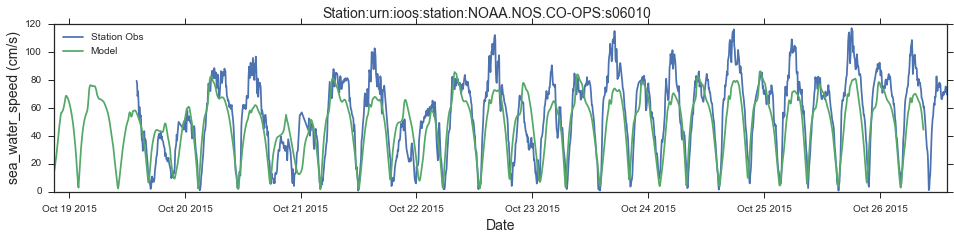

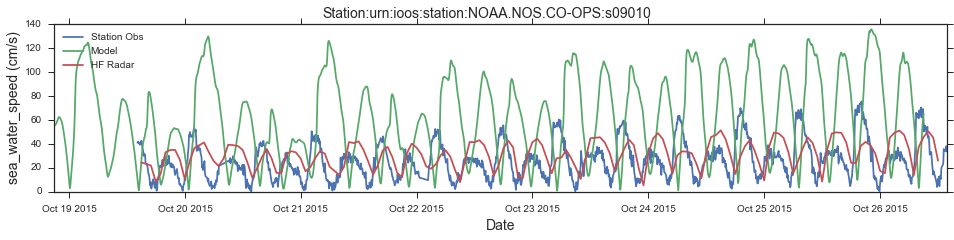

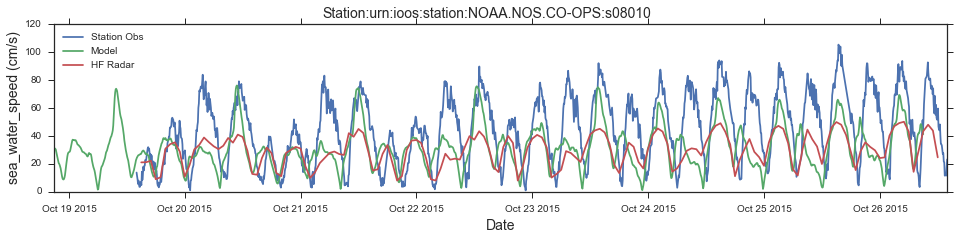

In [19]:
import matplotlib.pyplot as plt


for station_index in st_list.keys():
    df = st_list[station_index]['obsData']
    if st_list[station_index]['hasObsData']:
        fig = plt.figure(figsize=(16, 3))
        plt.plot(df.index, df['sea_water_speed (cm/s)'])
        fig.suptitle('Station:'+station_index, fontsize=14)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('sea_water_speed (cm/s)', fontsize=14)

        if station_index in model_data:
            df_model = model_data[station_index]['data']
            plt.plot(df_model.index, df_model['sea_water_speed (cm/s)'])
        for ent in df_list:
            if ent['ws_pts'] > 4:
                if station_index == ent['name']:
                    df = ent['data']
                    plt.plot(df.index, df['sea_water_speed (cm/s)'])
                    ent['valid'] = True
    l = plt.legend(('Station Obs', 'Model', 'HF Radar'), loc='upper left')

Any comparison will only make sense if we put that in a geographic context.
So let's create map and place the observations, model grid point, and HF-Radar
grid point on it.

In [20]:
import folium
from utilities import get_coordinates

station = st_list[list(st_list.keys())[0]]
mapa = folium.Map(location=[station["lat"], station["lon"]], zoom_start=10)
mapa.line(get_coordinates(bounding_box),
          line_color='#FF0000',
          line_weight=5)

for st in st_list:
    lat = st_list[st]['lat']
    lon = st_list[st]['lon']

    popupString = ('<b>Obs Location:</b><br>' + st + '<br><b>Source:</b><br>' +
                   st_list[st]['source'])

    if 'hasObsData' in st_list[st] and st_list[st]['hasObsData'] == False:
        mapa.circle_marker([lat, lon], popup=popupString, radius=1000,
                           line_color='#FF0000', fill_color='#FF0000',
                           fill_opacity=0.2)

    elif st_list[st]['source'] == "coops":
        mapa.simple_marker([lat, lon], popup=popupString,
                           marker_color="darkblue", marker_icon="star")
    elif st_list[st]['source'] == "ndbc":
        mapa.simple_marker([lat, lon], popup=popupString,
                           marker_color="darkblue", marker_icon="star")

try:
    for ent in df_list:
        lat = ent['lat']
        lon = ent['lon']
        popupstring = ("HF Radar: [" + str(lat) + ":"+str(lon) + "]" +
                       "<br>for<br>" + ent['name'])
        mapa.circle_marker([lat, lon], popup=popupstring, radius=500,
                           line_color='#FF0000', fill_color='#FF0000',
                           fill_opacity=0.5)
except:
    pass

try:
    for st in model_data:
        lat = model_data[st]['lat']
        lon = model_data[st]['lon']
        popupstring = ("HF Radar: [" + str(lat) + ":" + str(lon) + "]" +
                       "<br>for<br>" + ent['name'])
        mapa.circle_marker([lat, lon], popup=popupstring, radius=500,
                           line_color='#66FF33', fill_color='#66FF33',
                           fill_opacity=0.5)
except:
    pass

Bonus: we can add WMS tile layer for today's HF-Radar data on the map.
To enable the layer we must click on the top right menu of the interactive map.

In [21]:
jd_now = datetime.utcnow()
mapa.add_tile_layer(tile_name='hfradar 2km',
                    tile_url=('http://hfradar.ndbc.noaa.gov/tilesavg.php?'
                              's=10&e=100&x={x}&y={y}&z={z}&t=' +
                              str(jd_now.year) + '-' + str(jd_now.month) +
                              '-' + str(jd_now.day) + ' ' +
                              str(jd_now.hour-2) + ':00:00&rez=2'))

mapa.add_layers_to_map()

mapa

Map legend:

- Blue: observed station
- Green: model grid point
- Red: HF Radar grid point

In the beginning we raised the question:

    What is the extent of relevant meteorological and oceanographic data available in near real-time that could be used to support rapid deployment of a common operational picture to support response?

In order to answer that we tested how to get currents data for an area of interest, like the San Fransisco Bay.

The main downside was the fact that we had to augment the catalog search by hard-coding a known model for the area, the SFBOFS Model.
Still, the catalog was successful in finding near real-time observations from surrounding buoys/moorings, and HF-radar.

You can see the original IOOS System Test notebook [here](http://nbviewer.ipython.org/github/ioos/system-test/blob/master/Theme_2_Extreme_Events/Scenario_2B/HF_Radar_Currents/HF_Radar_Currents_west_coast.ipynb).

In [22]:
HTML(html)